In [1]:
import os

os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"] = '1'

In [2]:
import pandas as pd
from sklearn.model_selection import StratifiedKFold
import json

from torch.utils.data import Dataset,DataLoader
import torch
from torch import nn
from torch.nn.modules.loss import _WeightedLoss
import timm
import time
from tqdm import tqdm
import cv2
import numpy as np
#from torch.cuda.amp import autocast, GradScaler

%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [3]:
from albumentations import (
    HorizontalFlip, VerticalFlip, IAAPerspective, ShiftScaleRotate, CLAHE, RandomRotate90,
    Transpose, ShiftScaleRotate, Blur, OpticalDistortion, GridDistortion, HueSaturationValue,
    IAAAdditiveGaussianNoise, GaussNoise, MotionBlur, MedianBlur, IAAPiecewiseAffine, RandomResizedCrop,
    IAASharpen, IAAEmboss, RandomBrightnessContrast, Flip, OneOf, Compose, Normalize, Cutout, CoarseDropout, ShiftScaleRotate, CenterCrop, Resize
)
from albumentations.pytorch import ToTensorV2

In [4]:
test_fold = 0
img_size = 512
bs = 16

In [5]:
CFG = {
    'fold_num': 0,
    'seed': 2021,
    'model_arch': 'tf_efficientnet_b4_ns',
    'img_size': 512,
    'epochs': 10,
    'train_bs': 16,
    'valid_bs': 32,
    'T_0': 10,
    'lr': 1e-4,
    'min_lr': 1e-6,
    'weight_decay':1e-6,
    'num_workers': 8,
    'accum_iter': 2, # suppoprt to do batch accumulation for backprop with effectively larger batch size
    'verbose_step': 1,
    'device': 'cuda:0'
}

In [6]:
TRAIN_AUGS = Compose([
            RandomResizedCrop(CFG['img_size'], CFG['img_size']),
            Transpose(p=0.5),
            HorizontalFlip(p=0.5),
            VerticalFlip(p=0.5),
            ShiftScaleRotate(p=0.5),
            HueSaturationValue(hue_shift_limit=0.2, sat_shift_limit=0.2, val_shift_limit=0.2, p=0.5),
            RandomBrightnessContrast(brightness_limit=(-0.1,0.1), contrast_limit=(-0.1, 0.1), p=0.5),
            Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225], max_pixel_value=255.0, p=1.0),
            CoarseDropout(p=0.5),
            Cutout(p=0.5),
            ToTensorV2(p=1.0),
        ], p=1.)
VAL_AUGS =  Compose([
            Resize(CFG['img_size'], CFG['img_size']),
            Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225], max_pixel_value=255.0, p=1.0),
            ToTensorV2(p=1.0),
        ], p=1.)
TEST_AUGS =  Compose([
            Resize(CFG['img_size'], CFG['img_size']),
            Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225], max_pixel_value=255.0, p=1.0),
            ToTensorV2(p=1.0),
        ], p=1.)

## Support Functions

In [7]:
def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = True
    
def get_img(path):
    im_bgr = cv2.imread(path)
    im_rgb = im_bgr[:, :, ::-1]
    #print(im_rgb)
    return im_rgb

## Read Data

In [8]:
data = pd.read_csv('train.csv')
data.head()

,image_id,label
0,1000015157.jpg,0
1,1000201771.jpg,3
2,100042118.jpg,1
3,1000723321.jpg,1
4,1000812911.jpg,3


21397

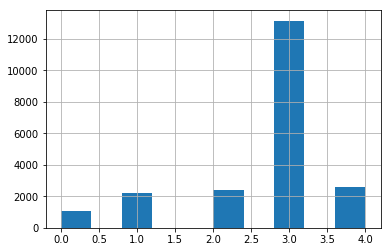

In [9]:
len(data)
data.label.hist()

In [10]:
mapping = json.load(open('label_num_to_disease_map.json', 'r'))
mapping

{'0': 'Cassava Bacterial Blight (CBB)',
 '1': 'Cassava Brown Streak Disease (CBSD)',
 '2': 'Cassava Green Mottle (CGM)',
 '3': 'Cassava Mosaic Disease (CMD)',
 '4': 'Healthy'}

In [11]:
data['fold'] = 0
strkf = StratifiedKFold(n_splits=5)
strkf.get_n_splits(data.image_id, data.label)
f = 0
for train_index, test_index in strkf.split(data.image_id, data.label):
    #print("TRAIN:", train_index, "TEST:", test_index)
    data.loc[data.index.isin(test_index), 'fold'] = f 
    f+=1

5

In [12]:
data.fold.value_counts()

1    4280
0    4280
4    4279
3    4279
2    4279
Name: fold, dtype: int64

In [13]:
train_data = data[data.fold != test_fold].reset_index(drop=True)
val_data = data[data.fold == test_fold].reset_index(drop=True)

## Cassava dataset

In [14]:
class CassavaDataset(Dataset):
    def __init__(self, df, mode = 'train'):
        super().__init__()
        self.df = df
        self.mode = mode
        
    def __len__(self, ):
        return len(self.df)
    
    def __getitem__(self, idx):
        row = self.df[self.df.index == idx]
        #print)
        image_name = row.image_id.values[0]
        img = get_img('train_images/'+ image_name)
        if self.mode == 'train':
            label = row.label.values[0]
            img = TRAIN_AUGS(image=img)['image']
            #img = np.moveaxis(img, 2, 0)
            return img, label
        elif self.mode == 'val':
            label = row.label.values[0]
            img = VAL_AUGS(image=img)['image']
            return img, label
        elif self.mode == 'test':
            img = TEST_AUGS(image=img)['image']
            return img
        else:
            print("Unknown mod type")

In [15]:
train_ds = CassavaDataset(train_data, mode = 'train')
valid_ds = CassavaDataset(val_data, mode = 'val')

In [16]:
train_ds[0][0].shape

torch.Size([3, 512, 512])

In [17]:
train_loader = torch.utils.data.DataLoader(
        train_ds,
        batch_size=bs,
        pin_memory=False,
        drop_last=False,
        shuffle=True,        
        num_workers=8,
        #sampler=BalanceClassSampler(labels=train_['label'].values, mode="downsampling")
    )
val_loader = torch.utils.data.DataLoader(
        valid_ds, 
        batch_size=bs*2,
        num_workers=8,
        shuffle=False,
        pin_memory=False,
)

In [18]:
def train_one_epoch(model, optim, train_loader, loss_fn):
    model = model.train();
    t = time.time()
    running_loss = None
    preds_all = []
    targets_all = []
    loss_sum = 0
    sample_num = 0
    pbar = tqdm(enumerate(train_loader), total=len(train_loader), position=0, leave=True)
    for step, (x, y_true) in pbar:
        x = x.to(device).float()
        y_true = y_true.to(device).long()
        y_pred = model(x)
        l = loss_fn(y_pred, y_true)
        optim.zero_grad()
        l.backward()
        optim.step()
        preds_all += [torch.argmax(y_pred, 1).detach().cpu().numpy()]
        targets_all += [y_true.detach().cpu().numpy()]
        if running_loss is None:
            running_loss = l.item()
        else:
            running_loss = running_loss * .99 + l.item() * .01

        if ((step + 1) % CFG['verbose_step'] == 0) or ((step + 1) == len(train_loader)):
            description = f'epoch {epoch} loss: {running_loss:.4f}'
            pbar.set_description(description)
    
    if scheduler is not None:
        scheduler.step()
    preds_all = np.concatenate(preds_all)
    targets_all = np.concatenate(targets_all)
    print("Target acc = ", (preds_all==targets_all).mean())

In [19]:
def valid_one_epoch(model, optim, val_loader, loss_fn):
    preds_all = []
    t = time.time()
    loss_sum = 0
    sample_num = 0
    preds_all = []
    targets_all = []
    pbar = tqdm(enumerate(val_loader), total=len(val_loader))
    with torch.no_grad():
        model = model.eval();
        
        for step, (x, y_true) in pbar:
            x = x.to(device).float()
            y_true = y_true.to(device).long()
            y_pred = model(x)
            preds_all += [torch.argmax(y_pred, 1).detach().cpu().numpy()]
            targets_all += [y_true.detach().cpu().numpy()]
            l = loss_fn(y_pred, y_true)
            loss_sum += l.item()*y_true.shape[0]
            sample_num += y_true.shape[0]  

        if ((step + 1) % CFG['verbose_step'] == 0) or ((step + 1) == len(val_loader)):
            description = f'epoch {epoch} loss: {loss_sum/sample_num:.4f}'
            pbar.set_description(description)
    
    preds_all = np.concatenate(preds_all)
    targets_all = np.concatenate(targets_all)
    print('validation multi-class accuracy = {:.4f}'.format((preds_all==targets_all).mean()))

In [20]:
# def valid_one_epoch(epoch, model, loss_fn, val_loader, device, scheduler=None, schd_loss_update=False):
#     model.eval()

#     t = time.time()
#     loss_sum = 0
#     sample_num = 0
#     image_preds_all = []
#     image_targets_all = []
    
#     pbar = tqdm(enumerate(val_loader), total=len(val_loader))
#     for step, (imgs, image_labels) in pbar:
#         imgs = imgs.to(device).float()
#         image_labels = image_labels.to(device).long()
        
#         image_preds = model(imgs)   #output = model(input)
        
#         image_preds_all += [torch.argmax(image_preds, 1).detach().cpu().numpy()]
#         image_targets_all += [image_labels.detach().cpu().numpy()]
        
#         loss = loss_fn(image_preds, image_labels)
        
#         loss_sum += loss.item()*image_labels.shape[0]
#         sample_num += image_labels.shape[0]  

#         if ((step + 1) % CFG['verbose_step'] == 0) or ((step + 1) == len(val_loader)):
#             description = f'epoch {epoch} loss: {loss_sum/sample_num:.4f}'
#             pbar.set_description(description)
    
#     image_preds_all = np.concatenate(image_preds_all)
#     image_targets_all = np.concatenate(image_targets_all)
#     print('validation multi-class accuracy = {:.4f}'.format((image_preds_all==image_targets_all).mean()))
    
#     if scheduler is not None:
#         if schd_loss_update:
#             scheduler.step(loss_sum/sample_num)
#         else:
#             scheduler.step()

In [21]:
# def train_one_epoch(epoch, model, loss_fn, optimizer, train_loader, device, scheduler=None, schd_batch_update=False):
#     model.train()

#     t = time.time()
#     running_loss = None

#     pbar = tqdm(enumerate(train_loader), total=len(train_loader))
#     for step, (imgs, image_labels) in pbar:
#         imgs = imgs.to(device).float()
#         image_labels = image_labels.to(device).long()

#         #print(image_labels.shape, exam_label.shape)
#         #with autocast():
#         image_preds = model(imgs)   #output = model(input)
        
#         loss = loss_fn(image_preds, image_labels)
#         loss.backward()
        
#         if running_loss is None:
#             running_loss = loss.item()
#         else:
#             running_loss = running_loss * .99 + loss.item() * .01

#         if ((step + 1) % CFG['verbose_step'] == 0) or ((step + 1) == len(train_loader)):
#             description = f'epoch {epoch} loss: {running_loss:.4f}'

#             pbar.set_description(description)

#     if scheduler is not None and not schd_batch_update:
#         scheduler.step()
        
# def valid_one_epoch(epoch, model, loss_fn, val_loader, device, scheduler=None, schd_loss_update=False):
#     model.eval()

#     t = time.time()
#     loss_sum = 0
#     sample_num = 0
#     image_preds_all = []
#     image_targets_all = []
    
#     pbar = tqdm(enumerate(val_loader), total=len(val_loader))
#     for step, (imgs, image_labels) in pbar:
#         imgs = imgs.to(device).float()
#         image_labels = image_labels.to(device).long()
        
#         image_preds = model(imgs)   #output = model(input)
        
#         image_preds_all += [torch.argmax(image_preds, 1).detach().cpu().numpy()]
#         image_targets_all += [image_labels.detach().cpu().numpy()]
        
#         loss = loss_fn(image_preds, image_labels)
        
#         loss_sum += loss.item()*image_labels.shape[0]
#         sample_num += image_labels.shape[0]  

#         if ((step + 1) % CFG['verbose_step'] == 0) or ((step + 1) == len(val_loader)):
#             description = f'epoch {epoch} loss: {loss_sum/sample_num:.4f}'
#             pbar.set_description(description)
    
#     image_preds_all = np.concatenate(image_preds_all)
#     image_targets_all = np.concatenate(image_targets_all)
#     print('validation multi-class accuracy = {:.4f}'.format((image_preds_all==image_targets_all).mean()))
    
#     if scheduler is not None:
#         if schd_loss_update:
#             scheduler.step(loss_sum/sample_num)
#         else:
#             scheduler.step()

In [22]:
class CassvaImgClassifier(torch.nn.Module):
    def __init__(self, model_arch, n_class, pretrained=False):
        super().__init__()
        self.model = timm.create_model(model_arch, pretrained=pretrained)
        n_features = self.model.classifier.in_features
        self.model.classifier = nn.Linear(n_features, n_class)
        '''
        self.model.classifier = nn.Sequential(
            nn.Dropout(0.3),
            #nn.Linear(n_features, hidden_size,bias=True), nn.ELU(),
            nn.Linear(n_features, n_class, bias=True)
        )
        '''
    def forward(self, x):
        x = self.model(x)
        return x

In [23]:
device = torch.device('cuda')
model = CassvaImgClassifier('tf_efficientnet_b4_ns', data.label.nunique(), pretrained=True).to(device)
#scaler = GradScaler()  
optimizer = torch.optim.Adam(model.parameters(), lr = 1e-4, weight_decay=1e-6)
scheduler = torch.optim.lr_scheduler.CosineAnnealingWarmRestarts(optimizer, T_0=10, T_mult=1, eta_min=1e-6, last_epoch=-1)
 
loss_tr = nn.CrossEntropyLoss().to(device)
loss_fn = nn.CrossEntropyLoss().to(device)
for epoch in range(10):
    print(f"epoch number {epoch}, lr = {optimizer.param_groups[0]['lr']}")
    train_one_epoch(model, optimizer, train_loader, loss_tr)
    valid_one_epoch(model, optimizer, val_loader, loss_fn)

    torch.save(model.state_dict(),'{}_fold_{}_{}'.format(CFG['model_arch'], test_fold, epoch))
            
#del model, optimizer, train_loader, val_loader, scaler, scheduler
torch.cuda.empty_cache()

epoch 0 loss: 0.4551: 100%|██████████| 1070/1070 [09:04<00:00,  1.96it/s]

Target acc =  0.8053397207454577



100%|██████████| 134/134 [00:37<00:00,  3.57it/s]


validation multi-class accuracy = 0.8661


epoch 1 loss: 0.3954: 100%|██████████| 1070/1070 [09:03<00:00,  1.97it/s]

Target acc =  0.8579190278670328



100%|██████████| 134/134 [00:37<00:00,  3.60it/s]


validation multi-class accuracy = 0.8731


epoch 2 loss: 0.3844: 100%|██████████| 1070/1070 [09:04<00:00,  1.96it/s]

Target acc =  0.870012268504995



100%|██████████| 134/134 [00:39<00:00,  3.43it/s]


validation multi-class accuracy = 0.8715


epoch 3 loss: 0.3454: 100%|██████████| 1070/1070 [09:05<00:00,  1.96it/s]

Target acc =  0.8808202371910966



100%|██████████| 134/134 [00:37<00:00,  3.57it/s]


validation multi-class accuracy = 0.8825


epoch 4 loss: 0.3411: 100%|██████████| 1070/1070 [09:04<00:00,  1.96it/s]

Target acc =  0.8843839457848922



100%|██████████| 134/134 [00:37<00:00,  3.59it/s]


validation multi-class accuracy = 0.8857


epoch 5 loss: 0.3176: 100%|██████████| 1070/1070 [09:06<00:00,  1.96it/s]

Target acc =  0.8951919144709938



100%|██████████| 134/134 [00:38<00:00,  3.51it/s]


validation multi-class accuracy = 0.8813


epoch 6 loss: 0.2811: 100%|██████████| 1070/1070 [09:04<00:00,  1.97it/s]

Target acc =  0.9020856458491558



100%|██████████| 134/134 [00:37<00:00,  3.59it/s]


validation multi-class accuracy = 0.8834


epoch 7 loss: 0.2126:   2%|▏         | 20/1070 [00:10<08:47,  1.99it/s]

KeyboardInterrupt: 

In [24]:
epoch = 6
model.load_state_dict(torch.load('{}_fold_{}_{}'.format(CFG['model_arch'], test_fold, epoch)))

<All keys matched successfully>

In [25]:
preds_all = []
t = time.time()
loss_sum = 0
sample_num = 0
preds_all = []
targets_all = []
pbar = tqdm(enumerate(val_loader), total=len(val_loader), position=0, leave=True)
with torch.no_grad():
    model = model.eval();
    for step, (x, y_true) in pbar:
        x = x.to(device).float()
        y_true = y_true.to(device).long()
        y_pred = model(x)
        preds_all += [torch.argmax(y_pred, 1).detach().cpu().numpy()]
        targets_all += [y_true.detach().cpu().numpy()]
        l = loss_fn(y_pred, y_true)
        loss_sum += l.item()*y_true.shape[0]
        sample_num += y_true.shape[0]  

    if ((step + 1) % CFG['verbose_step'] == 0) or ((step + 1) == len(val_loader)):
        description = f'epoch {epoch} loss: {loss_sum/sample_num:.4f}'
        pbar.set_description(description)

preds_all = np.concatenate(preds_all)
targets_all = np.concatenate(targets_all)

100%|██████████| 134/134 [00:37<00:00,  3.61it/s]


In [26]:
len(val_data)

4280

In [27]:
len(preds_all)

4280

In [28]:
right_guesses = np.where(preds_all == targets_all)[0]
wrong_guesses = np.where(preds_all != targets_all)[0]

In [29]:
len(right_guesses), len(wrong_guesses) 

(3781, 499)

## Plot few wrong guesses

In [30]:
ind = wrong_guesses[0]
predicted_label = preds_all[ind]
true_label = targets_all[ind]
mapping[str(predicted_label)], mapping[str(true_label)]

('Healthy', 'Cassava Brown Streak Disease (CBSD)')

In [31]:
path = val_data.iloc[ind].image_id


In [32]:
# #### img = get_img('train_images/'+path)
# from matplotlib.pyplot import figure
# figure(num=None, figsize=(8, 6), dpi=80, facecolor='w', edgecolor='k')
# t = plt.title(f'predict:{mapping[str(predicted_label)]}, actual: {mapping[str(true_label)]}')
# plt.imshow(img)
# plt.show()

In [33]:
def plot_wrong_answers(n):
    fig=plt.figure(figsize=(20, 20))
    fig.suptitle('False positive')
    columns = n
    rows = n
    
    #mapping[str(predicted_label)], mapping[str(true_label)]
    for i in range(0, columns*rows):
        try:
            ind = wrong_guesses[np.random.randint(len(wrong_guesses))]
            predicted_label = preds_all[ind]
            true_label = targets_all[ind]
            path = val_data.iloc[ind].image_id
            img = get_img('train_images/'+path)
            ax = fig.add_subplot(rows, columns, i+1)
            ax.title.set_text(f'p:{mapping[str(predicted_label)]}, a: {mapping[str(true_label)]}')
            plt.imshow(img)
        except:
            pass
    plt.show()

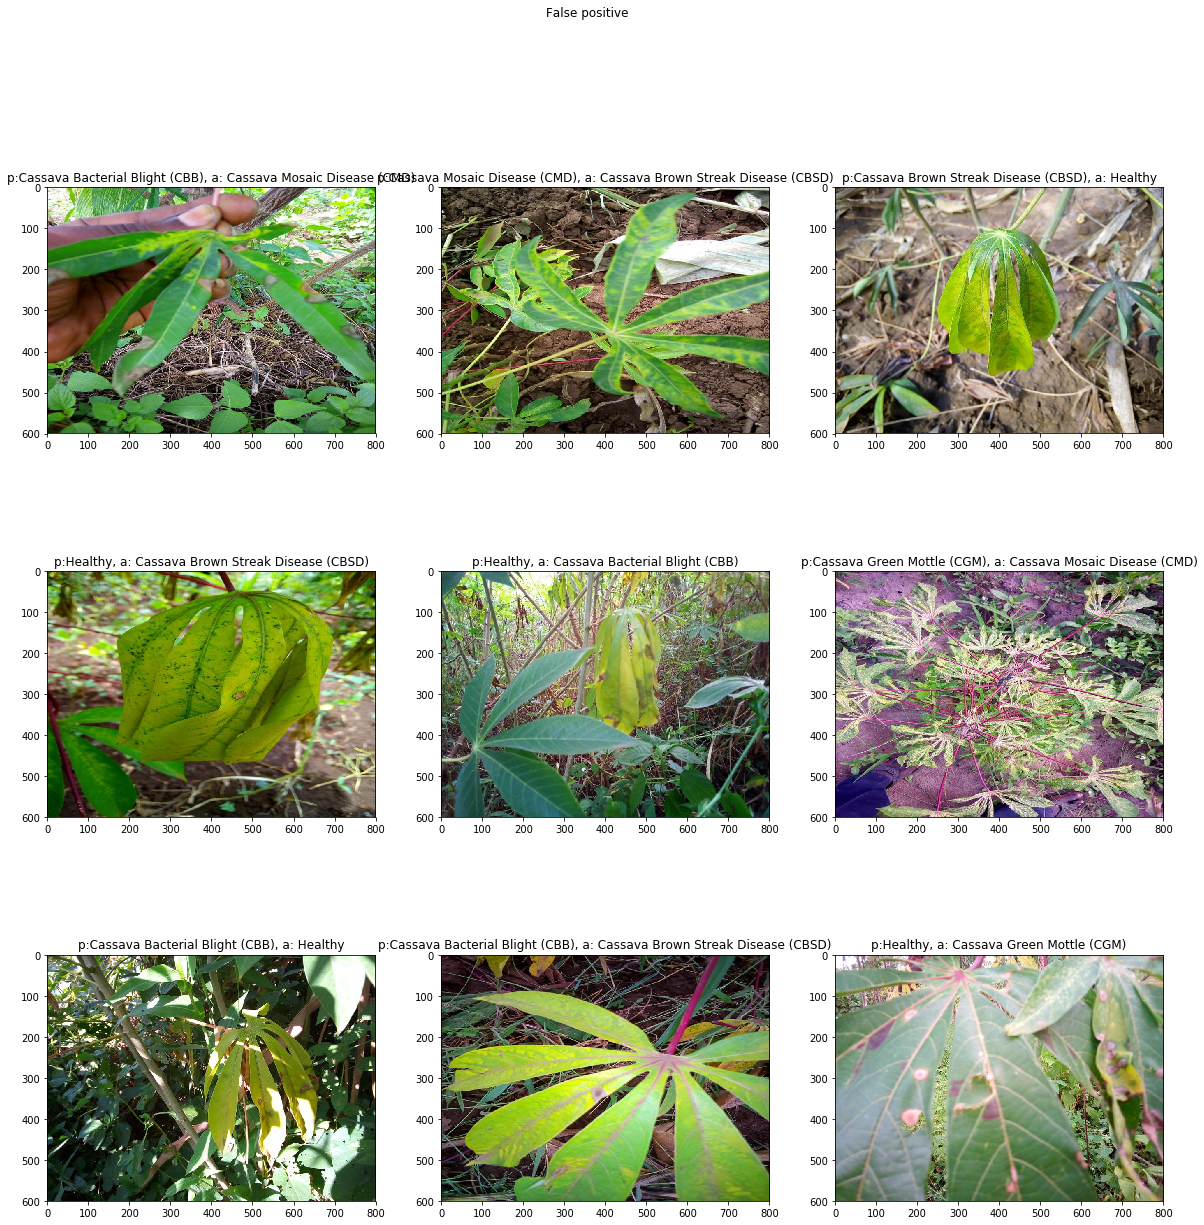

In [34]:
plot_wrong_answers(3)

In [35]:

from sklearn.metrics import confusion_matrix

cm = confusion_matrix(targets_all, preds_all)

In [36]:
cm = pd.DataFrame(cm)
cm.columns = [mapping[str(x)] for x in range(5)]
cm.index = [mapping[str(x)] for x in range(5)]

In [37]:
cm


,Cassava Bacterial Blight (CBB),Cassava Brown Streak Disease (CBSD),Cassava Green Mottle (CGM),Cassava Mosaic Disease (CMD),Healthy
Cassava Bacterial Blight (CBB),154,11,4,11,38
Cassava Brown Streak Disease (CBSD),36,335,11,12,44
Cassava Green Mottle (CGM),11,11,373,46,36
Cassava Mosaic Disease (CMD),5,11,34,2551,30
Healthy,57,23,23,45,368


In [38]:
targets_all[np.where(targets_all !=4)] = 1
targets_all[np.where(targets_all ==4)] = 0

preds_all[np.where(preds_all !=4)] = 1
preds_all[np.where(preds_all ==4)] = 0

In [39]:
cm = confusion_matrix(targets_all, preds_all)
cm = pd.DataFrame(cm)
cm.columns = ['Healthy', 'Not Healthy']
cm.index = ['Healthy', 'Not Healthy']
cm

,Healthy,Not Healthy
Healthy,368,148
Not Healthy,148,3616


## Inference

In [40]:
sample_submission = pd.read_csv('sample_submission.csv')
sample_submission.head()

,image_id,label
0,2216849948.jpg,4


In [41]:
import os
os.listdir('test_images/')

['2216849948.jpg']

In [56]:
class CassavaTestDataset(Dataset):
    def __init__(self, df, mode = 'train'):
        super().__init__()
        self.df = df
        self.mode = mode
        
    def __len__(self, ):
        return len(self.df)
    
    def __getitem__(self, idx):
        row = self.df[self.df.index == idx]
        #print)
        image_name = row.image_id.values[0]
        #print(image_name)
        img = get_img('test_images/'+ image_name)
        if self.mode == 'train':
            label = row.label.values[0]
            img = TRAIN_AUGS(image=img)['image']
            #img = np.moveaxis(img, 2, 0)
            return img, label
        elif self.mode == 'val':
            label = row.label.values[0]
            img = VAL_AUGS(image=img)['image']
            return img, label
        elif self.mode == 'test':
            img = TEST_AUGS(image=img)['image']
            return img
        else:
            print("Unknown mod type")

In [57]:
test_ds = CassavaTestDataset(sample_submission, mode = 'test')

In [58]:
test_ds[0]

tensor([[[ 0.1426,  0.3652,  0.7248,  ...,  0.5364,  0.4337, -0.7822],
         [ 0.2796,  0.2282,  0.4508,  ...,  0.5193,  0.5707, -0.3541],
         [ 0.2796,  0.1426,  0.2624,  ...,  0.5878,  0.8447,  0.6563],
         ...,
         [-1.5357, -1.5357, -1.5185,  ..., -1.6384, -1.5870, -1.5528],
         [-1.7069, -1.6555, -1.6042,  ..., -1.8097, -1.7583, -1.7069],
         [-1.8439, -1.7925, -1.7583,  ..., -1.7925, -1.7583, -1.7583]],

        [[ 0.2052,  0.5553,  1.0805,  ...,  1.2731,  1.0630, -0.2325],
         [ 0.3452,  0.4328,  0.8354,  ...,  1.2031,  1.1681,  0.1352],
         [ 0.3978,  0.3627,  0.6254,  ...,  1.1856,  1.3782,  1.0980],
         ...,
         [-1.1253, -1.0903, -1.0903,  ..., -1.7031, -1.6506, -1.6155],
         [-1.2654, -1.2129, -1.1429,  ..., -1.8782, -1.8256, -1.7731],
         [-1.3880, -1.3354, -1.3004,  ..., -1.8606, -1.8256, -1.8256]],

        [[ 0.0431,  0.3568,  0.8274,  ...,  0.2522,  0.3045, -0.7413],
         [ 0.2348,  0.2871,  0.6182,  ...,  0

In [59]:
test_loader = torch.utils.data.DataLoader(
        test_ds, 
        batch_size=bs*2,
        num_workers=8,
        shuffle=False,
        pin_memory=False,
)

In [60]:
def inference_one_epoch(model, data_loader, device):
    model.eval()
    image_preds_all = []
    
    pbar = tqdm(enumerate(data_loader), total=len(data_loader))
    with torch.no_grad():
        model = model.eval()
        for step, (imgs) in pbar:
            imgs = imgs.to(device).float()

            image_preds = model(imgs)   #output = model(input)
            image_preds_all += [torch.softmax(image_preds, 1).detach().cpu().numpy()]


        image_preds_all = np.concatenate(image_preds_all, axis=0)
    return image_preds_all

In [61]:
device = torch.device('cuda')
model = CassvaImgClassifier('tf_efficientnet_b4_ns', data.label.nunique(), pretrained=True).to(device)
model.load_state_dict(torch.load('{}_fold_{}_{}'.format(CFG['model_arch'], test_fold, 6)))
image_preds_all = inference_one_epoch(model, test_loader, device)
torch.cuda.empty_cache()

<All keys matched successfully>



100%|██████████| 1/1 [00:00<00:00,  5.97it/s]


In [63]:
image_preds_all

array([[0.00481949, 0.00850531, 0.09219746, 0.00291519, 0.8915626 ]],
      dtype=float32)

In [64]:
test = pd.DataFrame()
test['image_id'] = list(os.listdir('test_images/'))
test['label'] = np.argmax(image_preds_all, axis=1)

In [66]:
test

,image_id,label
0,2216849948.jpg,4
